# 훈련 코드

In [53]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
from google.colab import drive
import os

In [54]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 데이터 경로 설정 (Google Drive 내 경로에 맞게 수정하세요)
data_dir = '/content/drive/MyDrive/mbti_dataset'

# 데이터 변환 정의
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# 전체 데이터셋 로드
full_dataset = ImageFolder(data_dir, transform=data_transforms)


In [ ]:
# 데이터셋 분할 (80% 훈련, 10% 검증, 10% 테스트)
total_size = len(full_dataset)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [ ]:
# 모델 정의
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 16)  # 16 MBTI 유형

# GPU 사용 가능 여부 확인
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# 손실 함수와 옵티마이저 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 108MB/s]


In [ ]:
# 학습 루프
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    # 검증
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / len(train_dataset)
    val_loss = val_loss / len(val_dataset)
    val_accuracy = correct / total

    print(f'Epoch {epoch+1}/{num_epochs}, '
          f'Train Loss: {train_loss:.4f}, '
          f'Val Loss: {val_loss:.4f}, '
          f'Val Accuracy: {val_accuracy:.4f}')

print("Training complete!")

# 모델 저장
torch.save(model.state_dict(), '/content/drive/MyDrive/mbti_model.pth')


In [ ]:
# 테스트 셋으로 최종 평가
model.eval()
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

test_loss = test_loss / len(test_dataset)
test_accuracy = correct / total

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

# 저장된 모델 불러오고 실행하기

In [55]:
from PIL import Image
from IPython.display import display

In [56]:
# 모델 정의 (훈련 시 사용한 것과 동일한 구조)
model = models.resnet50(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 16)  # 16 MBTI 유형

# 저장된 모델 가중치 로드
model_path = '/content/drive/MyDrive/mbti_model.pth'
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

# GPU 사용 가능 여부 확인
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()  # 평가 모드로 설정

# 이미지 전처리를 위한 변환 정의
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [57]:
def predict_mbti(image_path):
    # 이미지 로드 및 전처리
    image = Image.open(image_path).convert('RGB')
    image = preprocess(image).unsqueeze(0).to(device)

    # 예측
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)

    # 결과 반환
    return predicted.item()

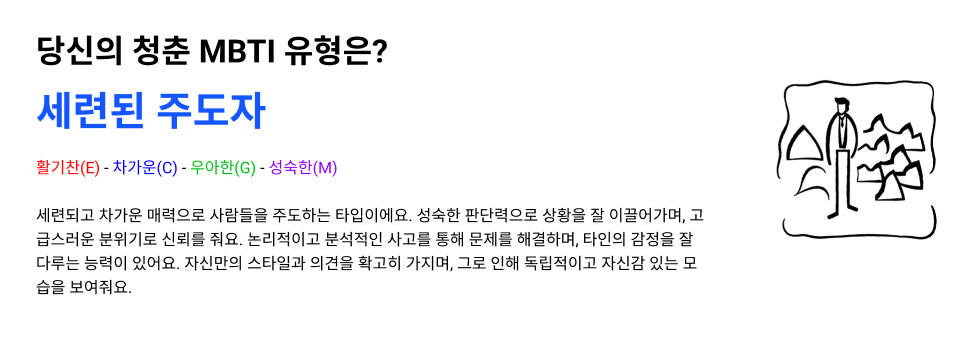

In [58]:
image_path = '/content/IMG_6818.jpg'  # 테스트할 이미지 경로
predicted_mbti = predict_mbti(image_path)
# print(f'Predicted personal 청춘 type: {predicted_mbti+1}')

# 예측값에 따라 이미지 경로 설정
result_image_path = f'/content/drive/MyDrive/mbti_result/{predicted_mbti + 1}.png'

# 이미지 표시
result_image = Image.open(result_image_path)
display(result_image)